In [1]:

## Libraries:

# a) Bond graphs
import BondGraphTools as bgt

# b) Data extraction
from pyomexmeta import RDF, eUriType
import os
import sys

# c) General
import copy
import difflib
import numpy as np
import pandas as pd
import math
import operator as op
import ast
import re

# d) Plot
import matplotlib.pyplot as plt
from matplotlib import markers
import matplotlib.font_manager as font_manager
import matplotlib.colors
from pylab import rcParams

# sbml
from libsbml import*
import simplesbml 

# Integration and fitting
from scipy.optimize import curve_fit, minimize, least_squares, newton_krylov, basinhopping
from scipy  import integrate
import scipy.stats as stats
from symfit import parameters, variables, log, Fit, GreaterThan, Model
from symfit.core.minimizers import BasinHopping
from gekko import GEKKO



The tests rely on tellurium to construct the models
Since tellurium is not installed the tests can't be run
If you want to run the tests, pip install tellurium first


In [25]:
fluxes = pd.read_csv('fluxes.txt', delimiter=' ', index_col=False)
species = pd.read_csv('species.txt', delimiter=' ', index_col=False)
solutions = pd.merge(fluxes,species)

sboRef = pd.read_csv('SBO.csv')
sboID = sboRef['http://www.geneontology.org/formats/oboInOwl#id']
sboMeaning = sboRef['http://www.w3.org/2000/01/rdf-schema#label']
sboSynonyms = sboRef['Synonyms']

reader = SBMLReader()
document = reader.readSBML("MODEL1004070000_url.xml")
document.getNumErrors()

model_lib = document.getModel()
model_simple = simplesbml.loadSBMLFile("MODEL1004070000_url.xml")


print ('Num compartmetns = ', model_simple.getNumCompartments())
print ('Num parameters =', model_simple.getNumParameters())
print ('Num species =', model_simple.getNumSpecies())
print ('Num reactions = ', model_simple.getNumReactions())
print (model_simple.getListOfCompartmentIds())
print (model_simple.getListOfAllSpecies())
print ('List of reactions = ', model_simple.getListOfReactionIds())
print ('List of rules = ', model_simple.getListOfRuleIds())
print ('List of parameters = ', model_simple.getListOfParameterIds())


Num compartmetns =  2
Num parameters = 0
Num species = 32
Num reactions =  30
['intracellular', 'extracellular']
['glucose_inside_cell', 'glucose_outside_cell', 'lactose', 'glucose_hexokinase', 'hexokinase', 'glucose_6_phosphate', 'hexokinase_inhibited', 'fructose_6_phosphate', 'fructose_16_diphosphate', 'dihydroxyacetone_3_phosphate', 'glyceraldehyde_3_phosphate', 'glycerol', 'pyruvate', '_6_phosphogluconolactone', 'NADP', 'NADPH', '_6_phosphogluconate', 'CO2A', 'ribulose_5_phosphate', 'ribose_5_phosphate', 'xylulose_5_phosphate', 'sedoheptulose_7_phosphate', 'erythrose_4_phosphate', 'lactate', 'acetyl_CoA', 'CO2B', 'CIT0C', 'CO2C', 'CO2D', 'fatty_acids', 'CIT2C', 'CIT1C']
List of reactions =  ['reaction_1', 'reaction_2', 'reaction_3', 'reaction_4', 'reaction_5', 'reaction_6', 'reaction_7', 'reaction_8', 'reaction_9', 'reaction_10', 'reaction_11', 'reaction_12', 'reaction_13', 'reaction_14', 'reaction_15', 'reaction_16', 'reaction_17', 'reaction_18', 'reaction_19', 'reaction_20', 'rea

In [26]:
reaction_reactants={}; reaction_products={}; reaction_modifiers={}; Synthesis=[]; Dtype=[]

for reaction in model_simple.getListOfReactionIds():
    reaction_reactants[reaction]=[]
    reaction_products[reaction]=[]
    reaction_modifiers[reaction]=[]
    
    reactNum=model_simple.getNumReactants(reaction)
    prodNum=model_simple.getNumProducts(reaction)
    modifierNum=model_simple.getNumModifiers(reaction)
    
    if reactNum is 0:
        Synthesis.append(reaction)
    if prodNum is 0:
        Dtype.append(reaction)
        
    if modifierNum is not 0:             
        for iii in range(modifierNum):
            reaction_modifiers[reaction].append((1,model_simple.getListOfModifiers(reaction)[0]))

    for i in range(reactNum):
        reaction_reactants[reaction].append((model_simple.getReactantStoichiometry(reaction, i),model_simple.getReactant(reaction, i)))


    for ii in range(prodNum):
        reaction_products[reaction].append((model_simple.getProductStoichiometry(reaction, ii),model_simple.getProduct(reaction, ii)))


            
            
reversibles=[]; irreversibles=[]; 

for (reaction,r) in zip(model_simple.getListOfReactionIds(),range(len(model_lib.getListOfReactions()))):
#     if model_simple.getNumModifiers(reaction) is not 0:  
#         irreversibles.append(reaction) 
        
#     else:
    
    if model_lib.getListOfReactions()[r].getReversible() is True:
        reversibles.append(reaction)
    else:
        if reaction not in [synth for synth in Synthesis] and reaction not in [d for d in Dtype]:
            irreversibles.append(reaction)  

 
        
speciesId=[]
for species in model_simple.getListOfAllSpecies():
    for i,reacs in enumerate(reaction_reactants.values()):
        if species in [reac[1] for reac in reacs] and species not in [d for d in speciesId]:
            speciesId.append(species)

    for i,prods in enumerate(reaction_products.values()):
        if species in [prod[1] for prod in prods] and species not in [d for d in speciesId]:
            speciesId.append(species)

In [4]:
reaction_reactants

{'reaction_1': [(1.0, 'glucose_outside_cell')],
 'reaction_2': [(1.0, 'glucose_inside_cell')],
 'reaction_3': [(1.0, 'glucose_inside_cell'), (1.0, 'hexokinase')],
 'reaction_4': [(1.0, 'glucose_hexokinase')],
 'reaction_5': [(1.0, 'glucose_6_phosphate'), (1.0, 'hexokinase')],
 'reaction_6': [(1.0, 'glucose_6_phosphate')],
 'reaction_7': [(1.0, 'fructose_6_phosphate')],
 'reaction_8': [(1.0, 'fructose_16_diphosphate')],
 'reaction_9': [(1.0, 'dihydroxyacetone_3_phosphate')],
 'reaction_10': [(1.0, 'dihydroxyacetone_3_phosphate')],
 'reaction_11': [(1.0, 'glyceraldehyde_3_phosphate')],
 'reaction_12': [(1.0, 'glucose_6_phosphate'), (1.0, 'NADP')],
 'reaction_13': [(1.0, '_6_phosphogluconolactone')],
 'reaction_14': [(1.0, '_6_phosphogluconate'), (1.0, 'NADP')],
 'reaction_15': [(1.0, 'ribulose_5_phosphate')],
 'reaction_16': [(1.0, 'ribulose_5_phosphate')],
 'reaction_17': [(1.0, 'ribose_5_phosphate'), (1.0, 'xylulose_5_phosphate')],
 'reaction_18': [(1.0, 'erythrose_4_phosphate'),
  (1.

In [5]:
reaction_products

{'reaction_1': [(1.0, 'glucose_inside_cell')],
 'reaction_2': [(1.0, 'lactose')],
 'reaction_3': [(1.0, 'glucose_hexokinase')],
 'reaction_4': [(1.0, 'glucose_6_phosphate'), (1.0, 'hexokinase')],
 'reaction_5': [(1.0, 'hexokinase_inhibited')],
 'reaction_6': [(1.0, 'fructose_6_phosphate')],
 'reaction_7': [(1.0, 'fructose_16_diphosphate')],
 'reaction_8': [(1.0, 'glyceraldehyde_3_phosphate'),
  (1.0, 'dihydroxyacetone_3_phosphate')],
 'reaction_9': [(1.0, 'glyceraldehyde_3_phosphate')],
 'reaction_10': [(1.0, 'glycerol')],
 'reaction_11': [(1.0, 'pyruvate')],
 'reaction_12': [(1.0, '_6_phosphogluconolactone'), (1.0, 'NADPH')],
 'reaction_13': [(1.0, '_6_phosphogluconate')],
 'reaction_14': [(1.0, 'ribulose_5_phosphate'), (1.0, 'CO2A'), (1.0, 'NADPH')],
 'reaction_15': [(1.0, 'ribose_5_phosphate')],
 'reaction_16': [(1.0, 'xylulose_5_phosphate')],
 'reaction_17': [(1.0, 'sedoheptulose_7_phosphate'),
  (1.0, 'glyceraldehyde_3_phosphate')],
 'reaction_18': [(1.0, 'fructose_6_phosphate'),


In [6]:
reversibles

['reaction_1',
 'reaction_3',
 'reaction_5',
 'reaction_6',
 'reaction_7',
 'reaction_8',
 'reaction_9',
 'reaction_10',
 'reaction_12',
 'reaction_13',
 'reaction_14',
 'reaction_15',
 'reaction_16',
 'reaction_17',
 'reaction_18',
 'reaction_19',
 'reaction_20',
 'reaction_27',
 'reaction_28']

In [7]:
irreversibles

['reaction_2',
 'reaction_4',
 'reaction_11',
 'reaction_21',
 'reaction_22',
 'reaction_23',
 'reaction_24',
 'reaction_25',
 'reaction_26',
 'reaction_29',
 'reaction_30']

In [41]:
# Reversible reactions ==> species constants approximation

Kp_to_Kr = []
rowM=[]
for reaction in reversibles:
    
    phi_Xr_1 = 1
    phi_Xp_1 = 1
    phi_Xr_e = 1
    phi_Xp_e = 1
    
    sigma = solutions[reaction][len(solutions[reaction])-1] / solutions[reaction][1]
    
    for stoichiometry,reactant in reaction_reactants[reaction]:
        
        phi_Xr_1 = phi_Xr_1 * solutions[reactant][1]
        phi_Xr_e = phi_Xr_e * solutions[reactant][len(solutions[reactant])-1]
        
        if reactant not in rowM:
            rowM.append(reactant)

    for stoichiometry,product in reaction_products[reaction]:        
        phi_Xp_1 = phi_Xp_1 * solutions[product][1]
        phi_Xp_e = phi_Xp_e * solutions[product][len(solutions[product])-1]
        
        if product not in rowM:
            rowM.append(product)

    Kp_to_Kr.append((sigma*phi_Xr_1 - phi_Xr_e)/(sigma*phi_Xp_1 - phi_Xp_e))



trueValues = Kp_to_Kr 

# M initial (regarding the steady-state ratios obtained in the previous stage)

M = np.zeros([len(trueValues),len(rowM)]) 

for reaction,i in zip(reversibles,range(len(reversibles))):
    for stoichiometry,reactant in reaction_reactants[reaction]:
        for r in range(len(rowM)):     
            if len(rowM[r])==len(reactant) and set(rowM[r]) == set(reactant):  
                M[i][r] = -stoichiometry


    for stoichiometry,product in reaction_products[reaction]:
        for r in range(len(rowM)):     
            if len(rowM[r])==len(product) and set(rowM[r]) == set(product):                    
                M[i][r] = stoichiometry


logTrueValues = [];

for k in trueValues:
    logTrueValues.append(math.log(k))

logTrueValues = np.array(logTrueValues)


Mpinv = np.linalg.pinv(np.array(M))
logU = Mpinv.dot(logTrueValues)

thermodynamics = [math.exp(i) for i in list(logU)]
for i in range(len(thermodynamics)):
    print(rowM[i],' ==> ',thermodynamics[i])

diff = logTrueValues-M.dot(logU)
np.exp(diff)

# irreversibleProducts=[]
# for reaction in irreversibles:
#     K_reactants = 1
#     for stoichiometry,reactant in reaction_reactants[reaction]:
#         for r in range(len(rowM)):     
#             if len(rowM[r])==len(reactant) and set(rowM[r]) == set(reactant):
#                 K_reactants = K_reactants * pow(thermodynamics[r],stoichiometry)
        
#     irreversibleProducts.append(1e-3*K_reactants)
        
        

glucose_outside_cell  ==>  0.32275662005935474
glucose_inside_cell  ==>  5.719247307451808
hexokinase  ==>  0.9472117746408554
glucose_hexokinase  ==>  0.5417338395618093
glucose_6_phosphate  ==>  34.29694673383605
hexokinase_inhibited  ==>  1.948798547121744
fructose_6_phosphate  ==>  0.9526929648286916
fructose_16_diphosphate  ==>  0.11432315577911915
glyceraldehyde_3_phosphate  ==>  0.11284400907138317
dihydroxyacetone_3_phosphate  ==>  0.044779368679118234
glycerol  ==>  0.009950970817581962
NADP  ==>  1.5443439348025987
_6_phosphogluconolactone  ==>  4.837776645814801
NADPH  ==>  0.6475241540854204
_6_phosphogluconate  ==>  0.483777664581484
ribulose_5_phosphate  ==>  2.0824987325777564
CO2A  ==>  0.03221222133790576
ribose_5_phosphate  ==>  0.6747295893551872
xylulose_5_phosphate  ==>  1.4087491426261283
sedoheptulose_7_phosphate  ==>  7.019459416666483
erythrose_4_phosphate  ==>  0.7908788594221129
pyruvate  ==>  7.745966692414839
lactate  ==>  0.12909944487358047
acetyl_CoA  ==

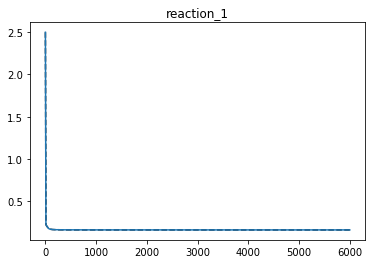

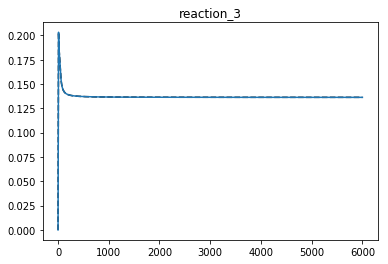

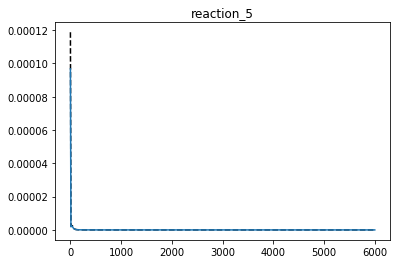

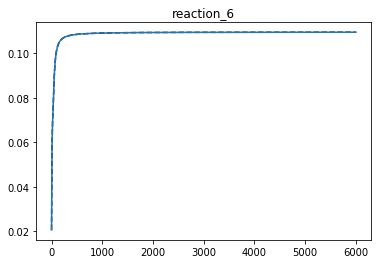

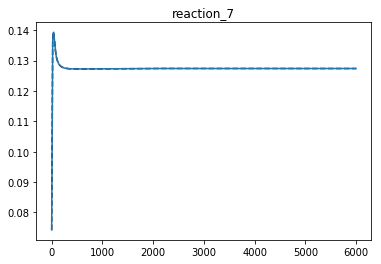

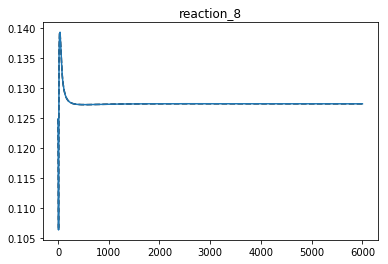

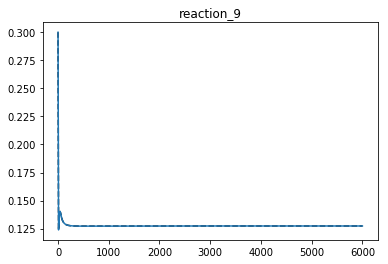

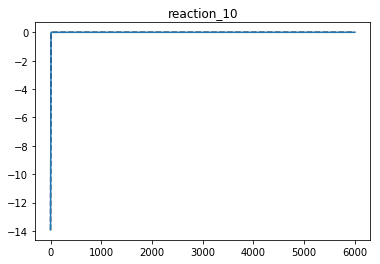

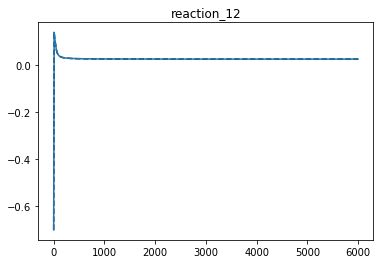

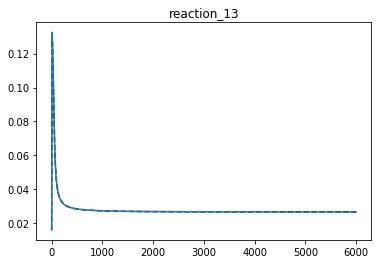

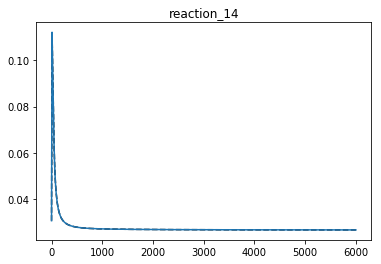

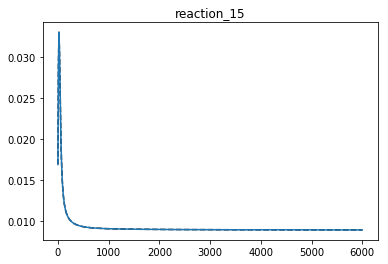

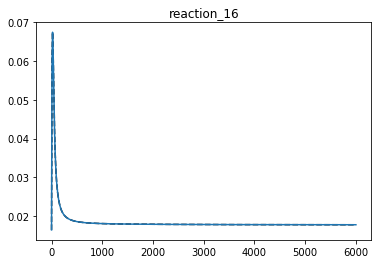

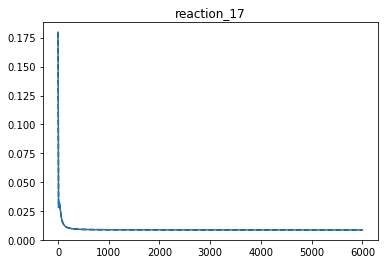

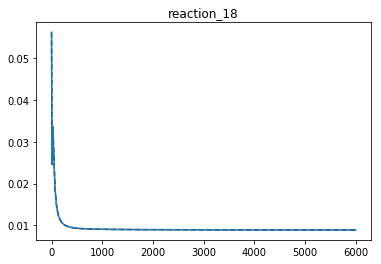

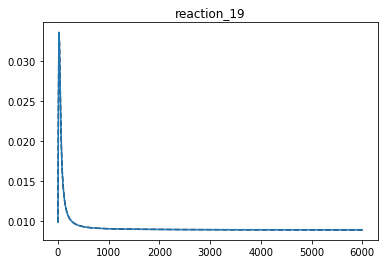

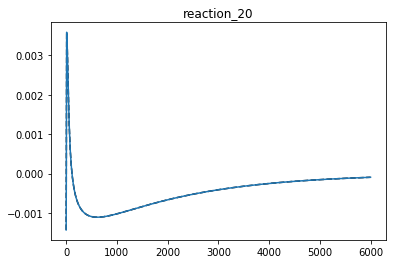

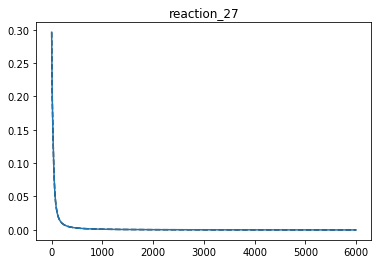

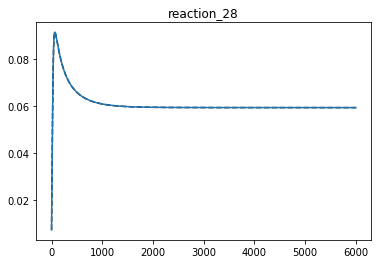

In [9]:
reactionRates = {}
for reaction in  reversibles:
    
    reactantsSpecies=[]
    productsSpecies=[]
    modifierSpecies=[]
    
    K_reactants = 1
    K_products = 1
    K_modifier = 1
    
    solve=tuple()
    
    for stoichiometry,reactant in reaction_reactants[reaction]:
        reactantsSpecies.append(reactant)        
        solve=solve+(pow(solutions[reactant],stoichiometry),)
        
        for i in range(len(rowM)):
            if len(rowM[i]) == len(reactant) and set(rowM[i]) == set(reactant):
                K_reactants = K_reactants * pow(thermodynamics[i],stoichiometry)   

    for stoichiometry,product in reaction_products[reaction]:
        productsSpecies.append(product)        
        solve=solve+(pow(solutions[product],stoichiometry),)
        
        for i in range(len(rowM)):
            if len(rowM[i]) == len(product) and set(rowM[i]) == set(product):
                K_products = K_products * pow(thermodynamics[i],stoichiometry)
            

#     if reaction in reaction_modifiers:
#         for modifier in reaction_modifiers[reaction]:
#             modifierSpecies.append(product)
#             solve=solve+(solutions[modifier],)
            
#             for i in range(len(rowM)):
#                 if len(rowM[i]) == len(modifier) and set(rowM[i]) == set(modifier):
#                     K_modifier = K_modifier *thermodynamics[i]
            
      
    def func(X, r):


        reactants = np.ones((len(solutions['time'])))
        products= np.ones((len(solutions['time'])))
#         modifiers = np.ones((len(solutions['time'])))


        for x in range(0,len(reactantsSpecies)):
            reactants = reactants * X[x]            

        for x in range(len(reactantsSpecies),len(reactantsSpecies)+len(productsSpecies)):
            products = products * X[x]
            
#         for x in range(len(reactantsSpecies)+len(productsSpecies),len(reactantsSpecies)+len(productsSpecies)+len(modifierSpecies)):
#             modifiers = modifiers * X[x]


#         v = r*(K_reactants*K_modifier*reactants*modifiers- K_products*K_modifier*products*modifiers)
        v = r*(K_reactants*reactants- K_products*products)


        return v


    bounds=[[0],[np.inf]]
    popt, pcov = curve_fit(func,solve,solutions[reaction], maxfev=300000, bounds=bounds)
    if popt[0]==1: #popt[1]==popt[2]==1:
        popt, pcov = curve_fit(func,solve,solutions[reaction], maxfev=300000, method='lm')

    reactionRates[reaction]=popt[0]

    
    
    reactants = np.ones((len(solutions['time'])))
    products = np.ones((len(solutions['time'])))
    for s,reac in reaction_reactants[reaction]:
        reactants=reactants*solutions[reac]
    for s,pro in reaction_products[reaction]:
        products=products*solutions[pro]
        
    plt.figure()
    plt.plot(solutions['time'],popt[0]*(K_reactants*reactants-K_products*products),'k--')
    plt.plot(solutions['time'],solutions[reaction])
    plt.title(reaction)

In [10]:
# Finding Enzyme_Intermediate coefficients


def enzymeOptimum(reaction,thermodynamics,enzymeAmounts,p):

    def func_v1(X,r1_Km,r1_KI):

        reactants = np.ones((len(solutions['time'])))
        modifiers = np.ones((len(solutions['time'])))
        Intermediate = p*np.ones((len(solutions['time'])))

        for x in range(0,len(reactantsSpecies)):
            reactants = reactants * X[x]            

        for x in range(len(reactantsSpecies),len(v1Species)):
            modifiers = modifiers * X[x]

        v1 = r1_Km*K_reactants*reactants*modifiers - r1_KI*Intermediate

        return v1


    def func_v2(X,r2_Km,r2_KI):

        products = np.ones((len(solutions['time'])))
        modifiers = np.ones((len(solutions['time'])))
        Intermediate = p*np.ones((len(solutions['time'])))

        for x in range(0,len(productsSpecies)):
            products = products * X[x]            

        for x in range(len(productsSpecies),len(v2Species)):
            modifiers = modifiers * X[x]

        v2 = r2_KI*Intermediate - r2_Km*K_products*products*modifiers 

        return v2

    
    reactantsSpecies=[]
    productsSpecies=[]
    modifierSpecies=[]
     
    K_reactants = 1
    K_products = 1
    K_modifier = 1
    
    solve=tuple()
    
    for stoichiometry,reactant in reaction_reactants[reaction]:
        reactantsSpecies.append(reactant)        
        solve=solve+(pow(solutions[reactant],stoichiometry),)
        
        for i in range(len(rowM)):
            if len(rowM[i]) == len(reactant) and set(rowM[i]) == set(reactant):
                K_reactants = K_reactants * pow(thermodynamics[i],stoichiometry)   

    for stoichiometry,product in reaction_products[reaction]:
        productsSpecies.append(product)        
        solve=solve+(pow(solutions[product],stoichiometry),)
        
        for i in range(len(rowM)):
            if len(rowM[i]) == len(product) and set(rowM[i]) == set(product):
                K_products = K_products * pow(thermodynamics[i],stoichiometry)
            

# tuple the solutions for the reactants(+modifiers)
    if reaction in reaction_modifiers:
        v1Species = reactantsSpecies+[m for m in reaction_modifiers[reaction] if reaction_modifiers[reaction]]
        v1solve=tuple()
        for i,ALL in enumerate(v1Species):

            v1solve=v1solve+(solutions[ALL],)

    else:
        v1Species = reactantsSpecies
        v1solve=tuple()
        for i,ALL in enumerate(v1Species):

            v1solve=v1solve+(solutions[ALL],)

    # tuple the solutions for the products(+modifiers)
    if reaction in reaction_modifiers:
        v2Species = productsSpecies+[m for m in reaction_modifiers[reaction] if reaction_modifiers[reaction]]
        v2solve=tuple()
        for i,ALL in enumerate(v2Species):

            v2solve=v2solve+(solutions[ALL],)
    else:
        v2Species = productsSpecies    
        v2solve=tuple()
        for i,ALL in enumerate(v2Species):

            v2solve=v2solve+(solutions[ALL],)

            


    v1 =  solutions[reaction]
    v2 =  solutions[reaction]
    

    enzymeCoeff=[];

    bounds=[[0,0],[np.inf,np.inf]]
    popt, pcov = curve_fit(func_v1,v1solve,v1, maxfev=5000, bounds=bounds) 
    enzymeCoeff.append(('r1km',popt[0])); enzymeCoeff.append(('r1ki',popt[1]))

    popt, pcov = curve_fit(func_v2,v2solve,v2, maxfev=5000, bounds=bounds)
    enzymeCoeff.append(('r2km',popt[0])); enzymeCoeff.append(('r2ki',popt[1]))


    enzymeCatalyzedComps = ['ra','rb','Km','Ki']
    M_enzyme=np.zeros((4,4))
    trueCoefficients=[]
    for coeffs in enzymeCoeff:
        if coeffs[0] == 'r1km':
            M_enzyme[0][0] = 1
            M_enzyme[0][2] = 1
        if coeffs[0] == 'r1ki':
            M_enzyme[1][0] = 1
            M_enzyme[1][3] = 1
        if coeffs[0] == 'r2km':
            M_enzyme[2][1] = 1
            M_enzyme[2][2] = 1
        if coeffs[0] == 'r2ki':
            M_enzyme[3][1] = 1
            M_enzyme[3][3] = 1

        trueCoefficients.append(coeffs[1])

    logTrueCoefficients = [];
    for k in trueCoefficients:
        logTrueCoefficients.append(math.log(k))
    logTrueCoefficients = np.array(logTrueCoefficients)

    Mpinv = np.linalg.pinv(np.array(M_enzyme))
    logU = Mpinv.dot(logTrueCoefficients)
    
    enzymeAmounts[(reaction,p)]=[]
    enzymeAmounts[(reaction,p)] = [(j,math.exp(i)) for j,i in zip(enzymeCatalyzedComps,list(logU))]
    diff = logTrueCoefficients-M_enzyme.dot(logU)

    
    return [diff,enzymeAmounts]

    
    


In [11]:
enzymeAmounts={}
optEnzymeAmounts={}

for reaction in irreversibles:
    differences={}  
    K_reactants = 1
    K_products = 1
    for stoichiometry,reactant in reaction_reactants[reaction]:
        for i in range(len(rowM)):
            if len(rowM[i]) == len(reactant) and set(rowM[i]) == set(reactant):
                K_reactants = K_reactants * pow(thermodynamics[i],stoichiometry)
    for stoichiometry,product in reaction_products[reaction]:
        for i in range(len(rowM)):
            if len(rowM[i]) == len(product) and set(rowM[i]) == set(product):
                K_products = K_products * pow(thermodynamics[i],stoichiometry)
                
    Range=np.arange(1e-4*K_reactants, 1*K_reactants, 1e-3)      
    for p in Range:
        [diff,enzymeAmounts] = enzymeOptimum(reaction,thermodynamics,enzymeAmounts,p)
        summ = 0
        for d in range(len(np.exp(diff))):
            summ = summ + abs(1- (np.exp(diff)[d]))
        differences[p]=[]
        differences[p].append(summ)
        
    
    
    minP=min(differences, key=differences.get)

    print('The optimum concentration for Intermediate species in ',reaction,'is :',minP)
    
    optEnzymeAmounts[(reaction, minP)] = []
    optEnzymeAmounts[(reaction, minP)] = copy.deepcopy(enzymeAmounts[(reaction, minP)])
    

The optimum concentration for Intermediate species in  reaction_2 is : 0.4345719247307452
The optimum concentration for Intermediate species in  reaction_4 is : 0.5410541733839562
The optimum concentration for Intermediate species in  reaction_11 is : 0.0010112844009071383
The optimum concentration for Intermediate species in  reaction_21 is : 0.7577745966692415
The optimum concentration for Intermediate species in  reaction_22 is : 0.12502495147935722
The optimum concentration for Intermediate species in  reaction_23 is : 0.1727745966692415
The optimum concentration for Intermediate species in  reaction_24 is : 0.4217745966692415
The optimum concentration for Intermediate species in  reaction_25 is : 1.9767745966692414
The optimum concentration for Intermediate species in  reaction_26 is : 0.004064752415408542
The optimum concentration for Intermediate species in  reaction_29 is : 1.5654280370476699
The optimum concentration for Intermediate species in  reaction_30 is : 0.4481


In [12]:
optEnzymeAmounts

{('reaction_2', 0.4345719247307452): [('ra', 0.014107937360014842),
  ('rb', 0.0009041513483810468),
  ('Km', 0.00015351408453395115),
  ('Ki', 0.08309146763736676)],
 ('reaction_4', 0.5410541733839562): [('ra', 0.007150269795690257),
  ('rb', 34.41671435673469),
  ('Km', 1474.499208489883),
  ('Ki', 0.00016689652440294791)],
 ('reaction_11', 0.0010112844009071383): [('ra', 5.322862779938867),
  ('rb', 0.008839775639680086),
  ('Km', 0.004460996975701947),
  ('Ki', 10.547622648423665)],
 ('reaction_21', 0.7577745966692415): [('ra', 0.1366089879843695),
  ('rb', 0.0006835861019622251),
  ('Km', 0.0008517499979049955),
  ('Ki', 0.10963781135184161)],
 ('reaction_22', 0.12502495147935722): [('ra', 1.8253210895343843),
  ('rb', 1.5780313528537444e-05),
  ('Km', 1.5421743065348507e-05),
  ('Ki', 1.8677615728033237)],
 ('reaction_23', 0.1727745966692415): [('ra', 0.006778984121624833),
  ('rb', 0.08400644016500501),
  ('Km', 0.011318207906475189),
  ('Ki', 0.05031523795096531)],
 ('reaction_

In [13]:
# BG model (ALL)
BGmodel=bgt.new(name='BGmodel')
idealGassConstant=8.314
T= 310

check=[]

BGspecies=[]; BGzeroJunc=[]; BGreactions=[]; oneJunc_reac=[]; oneJunc_prod=[]; TF=[];

    
for reaction in reversibles:
        
    BGreactions.append(bgt.new("Re", name=reaction, library="BioChem", value={'R':idealGassConstant, 'T':T}))

    oneJunc_reac.append(bgt.new("1", name='oneReac '+reaction)) 
    oneJunc_prod.append(bgt.new("1", name='oneProd '+reaction))

    
    for stoichiometry,reactant in reaction_reactants[reaction]:
        if stoichiometry != 1:
            TF.append(bgt.new('TF', name='oneReac '+reaction+' '+reactant, value=stoichiometry))
            
    for stoichiometry,product in reaction_products[reaction]:
        if stoichiometry != 1:
            TF.append(bgt.new('TF', name='oneProd '+reaction+' '+product, value=1/stoichiometry))
            
#     for forwardStoichiometry,backwardStoichiometry in refinedStoichiometries[reaction]:
#         TF.append(bgt.new('TF', name='oneReac '+reaction, value=forwardStoichiometry))
#         TF.append(bgt.new('TF', name='oneProd '+reaction, value=1/backwardStoichiometry))
        
for reaction in irreversibles:
        
    BGreactions.append(bgt.new("Re", name=reaction+' ra', library="BioChem", value={'R':idealGassConstant, 'T':T}))
    BGreactions.append(bgt.new("Re", name=reaction+' rb', library="BioChem", value={'R':idealGassConstant, 'T':T}))

    oneJunc_reac.append(bgt.new("1", name='oneReac '+reaction+' ra')) 
    oneJunc_reac.append(bgt.new("1", name='oneReac '+reaction+' rb')) 
    oneJunc_prod.append(bgt.new("1", name='oneProd '+reaction+' ra'))
    oneJunc_prod.append(bgt.new("1", name='oneProd '+reaction+' rb'))

    BGspecies.append(bgt.new("Ce_S", name=reaction+' I', library="BioChem", value={'R':idealGassConstant, 'T':T}))
    BGzeroJunc.append(bgt.new("0", name=reaction+' I'))    

    if reaction_modifiers[reaction] == []:
        BGspecies.append(bgt.new("Ce_S", name=reaction+' M', library="BioChem", value={'R':idealGassConstant, 'T':T}))
        BGzeroJunc.append(bgt.new("0", name=reaction+' M')) 
    else:
        pass # Later add any existing modifier to the BGspecies

    
for species in speciesId:
    diff = solutions[species].diff() 
    diff.fillna(method='bfill', inplace=True)
    if diff.all() != 0:
        BGspecies.append(bgt.new("Ce", name=species, library="BioChem", value={'R':idealGassConstant, 'T':T}))
        BGzeroJunc.append(bgt.new("0", name=species)) 
    elif diff.all() == 0:
        BGspecies.append(bgt.new("Ce_S", name=species, library="BioChem", value={'R':idealGassConstant, 'T':T}))
        BGzeroJunc.append(bgt.new("0", name=species)) 
    
    
for comp in TF:
    bgt.add(BGmodel,comp)
    
for comp1,comp2 in zip(BGspecies,BGzeroJunc):
    bgt.add(BGmodel,comp1,comp2)
    
for comp1,comp2,comp3 in zip(BGreactions,oneJunc_reac,oneJunc_prod):
    bgt.add(BGmodel,comp1,comp2,comp3)

In [14]:
# connections
connections = []

for z in BGzeroJunc:
    for s in BGspecies:
        if len(z.name)==len(s.name) and set(z.name) == set(s.name):
            connections.append((z,s))
    

for r in BGreactions:
    for oneR,oneP in zip(oneJunc_reac,oneJunc_prod):    
        if len('oneReac '+r.name) == len(oneR.name) and set('oneReac '+r.name) == set(oneR.name):
            connections.append((oneR,r))
            
            
        if len('oneProd '+r.name) == len(oneP.name) and set('oneProd '+r.name) == set(oneP.name):
            connections.append((r,oneP))

# for oneR,oneP in zip(oneJunc_reac,oneJunc_prod):
#     for TFcomp in TF:
#         if len(TFcomp.name) == len(oneR.name) and (TFcomp.name) == (oneR.name):
#             connections.append((oneR,(TFcomp,0)))
#             for r in BGreactions:
#                 if len(TFcomp.name) == len('oneReac '+r.name) and (TFcomp.name) == ('oneReac '+r.name):
#                     connections.append(((TFcomp,1),r))

#         if len(TFcomp.name) == len(oneP.name) and (TFcomp.name) == (oneP.name):
#             connections.append(((TFcomp,1),oneP))
#             for r in BGreactions:
#                 if len(TFcomp.name) == len('oneProd '+r.name) and (TFcomp.name) == ('oneProd '+r.name):
#                     connections.append((r,(TFcomp,0)))

                
                
for reaction in reversibles:
    for oneR in oneJunc_reac:
        for xR in oneR.name.split(sep=" "):
            if len(reaction)==len(xR) and set(reaction) == set(xR):

                for z in BGzeroJunc:
                    for value in reaction_reactants[reaction]:
                        if len(z.name)==len(value[1]) and (z.name) == (value[1]):
                            if value[0]!=1:
                                for TFcomp in TF:
                                    if len(TFcomp.name) == len('oneReac '+reaction+' '+z.name) and (TFcomp.name) == ('oneReac '+reaction+' '+z.name):
                                        connections.append((z,(TFcomp,0)))
                                        connections.append(((TFcomp,1),oneR))
                            else:
                                connections.append((z,oneR))
#                     if reaction in reaction_modifiers:
#                         for modifier in reaction_modifiers[reaction]: # if the reaction has a modifier in the model          
#                             if len(modifier)==len(z.name) and set(modifier) == set(z.name):
#                                 connections.append((z,oneR))  
                                    
    for oneP in oneJunc_prod:
        for xP in oneP.name.split(sep=" "):
            if len(reaction)==len(xP) and set(reaction) == set(xP):

                for z in BGzeroJunc:
                    for value in reaction_products[reaction]:
                        if len(z.name)==len(value[1]) and (z.name) == (value[1]):
                            if value[0]!=1:
                                for TFcomp in TF:
                                    if len(TFcomp.name) == len('oneProd '+reaction+' '+z.name) and (TFcomp.name) == ('oneProd '+reaction+' '+z.name):
                                        connections.append((oneP,(TFcomp,0)))
                                        connections.append(((TFcomp,1),z))
                            else:
                                connections.append((oneP,z))

#                     if reaction in reaction_modifiers:
#                         for modifier in reaction_modifiers[reaction]: # if the reaction has a modifier in the model        
#                             if len(modifier)==len(z.name) and set(modifier) == set(z.name):
#                                 connections.append((oneP,z))



for reaction in irreversibles:
    
    for oneR in oneJunc_reac:
        for xR in oneR.name.split(sep=" "):
            if len(reaction)==len(xR) and set(reaction) == set(xR):
                if 'ra' in [one for one in oneR.name.split(sep=" ")]: # reactants to the Re:a (one-junc)                    
                    for z in BGzeroJunc:
                        for stoi,reactant in reaction_reactants[reaction]:
                            if len(z.name)==len(reactant) and set(z.name) == set(reactant):
                                connections.append((z,oneR))    
                                
                    
                                
                        if reaction_modifiers[reaction] !=[]: # if the irreversible reaction has a modifier in the model        
                            if len(reaction_modifiers[reaction][0])==len(z.name) and set(reaction_modifiers[reaction][0]) == set(z.name):
                                connections.append((z,oneR)) 
                        else:
                            if len(reaction+' M') == len(z.name) and set(reaction+' M') == set(z.name):
                                connections.append((z,oneR)) 
                            
                if 'rb' in [one for one in oneR.name.split(sep=" ")]:  # the Intermediate product to the Re:b (one-junc)                                        
                    for z in BGzeroJunc:
                        if len(z.name) == len(reaction+' I') and set(z.name) == set(reaction+' I'):
                                connections.append((z,oneR))

    for oneP in oneJunc_prod:
        for xP in oneP.name.split(sep=" "):
            if len(reaction)==len(xP) and set(reaction) == set(xP):
                if 'ra' in [one for one in oneP.name.split(sep=" ")]: # Re:a (one-junc) to the Intermediate product                                        
                    for z in BGzeroJunc:
                        if len(z.name) == len(reaction+' I') and set(z.name) == set(reaction+' I'):
                            connections.append((oneP,z))
                if 'rb' in [one for one in oneP.name.split(sep=" ")]: # Re:b (one-junc) to the products                                        
                    for z in BGzeroJunc:
                        for value in reaction_products[reaction]:
                            if len(z.name)==len(value[1]) and set(z.name) == set(value[1]):
                                connections.append((oneP,z))
                                
                                
                        if reaction_modifiers[reaction] !=[]: # if the irreversible reaction has a modifier in the model        
                            if len(reaction_modifiers[reaction][0])==len(z.name) and set(reaction_modifiers[reaction][0]) == set(z.name):
                                connections.append((oneP,z))
                        else:
                            if len(reaction+' M') == len(z.name) and set(reaction+' M') == set(z.name):
                                connections.append((oneP,z)) 
                                    
    




for tail,head in connections:
    bgt.connect(tail,head)

In [15]:
# Setting the values in BGs
           
for BGreaction in BGreactions:
    if BGreaction.name in [key for key in reactionRates]: # meaning it's reversible
        bgt.set_param(BGreaction,'r',reactionRates[BGreaction.name])
    else:
        terms = BGreaction.name.split(" ")   # reaction rates for irreversibles
        for key in optEnzymeAmounts:
            if key[0] in [x for x in terms] and 'ra' in [x for x in terms]:
                for val in optEnzymeAmounts[key]:
                    if 'ra' == val[0]:
                        bgt.set_param(BGreaction,'r',val[1])

            if key[0] in [x for x in terms] and 'rb' in [x for x in terms]:
                for val in optEnzymeAmounts[key]:
                    if 'rb' == val[0]:
                        bgt.set_param(BGreaction,'r',val[1])
        
    

for bg in BGspecies:
    terms = bg.name.split(" ")
    for key in optEnzymeAmounts: # for intermediate and modifying species in irreversible reactions
        if key[0] in [x for x in terms] and 'M' in [term for term in terms]:
            for value in optEnzymeAmounts[key]:
                if 'Km' == value[0]:
                    bgt.set_param(bg,'k',value[1])
                    
        if key[0] in [x for x in terms] and 'I' in [term for term in terms]:
            for value in optEnzymeAmounts[key]:
                if 'Ki' == value[0]:
                    bgt.set_param(bg,'k',value[1])
                    
    for i in range(len(rowM)): 
        if bg.name == rowM[i]:
            bgt.set_param(bg,'k',thermodynamics[i])

In [16]:
# Adding the boundary conditions of Sf/Se the model for Synthesis/Dtype(Degradation,Decay )

   
for reaction in Dtype:
    for stoichiometry,reactant in reaction_reactants[reaction]:
        for  i in range(len(rowM)):
            if len(rowM[i])==len(reactant) and set(rowM[i])==set(reactant):
                K_reactants = thermodynamics[i]
            
        
    def funcDtype(X, r):

        products= np.ones((len(solutions['time'])))          


        v = r*(K_reactants*X - (0.001*K_reactants)*products)

        return v
    
    bounds=[[0],[np.inf]]
    popt, pcov = curve_fit(funcDtype,solutions[reactant],solutions[reaction], maxfev=5000, bounds=bounds)
    if popt[0]==1:
        popt, pcov = curve_fit(funcDtype,solutions[reactant],solutions[reaction], maxfev=5000, method='lm')
        
    rateDtype = popt[0]


    bgt.add(BGmodel,bgt.new("Re", name=reaction, library="BioChem", value={'r':rateDtype ,'R':idealGassConstant, 'T':T}))
    
    for bg in [s for s in BGmodel.components if s.metamodel=='C' and s.name == reactant]:
        K_aux = 0.001 * bg._params['k']['value']
        bgt.add(BGmodel,bgt.new("Ce_S", name=reaction+' C_aux', library="BioChem", value={'k':K_aux ,'R':idealGassConstant, 'T':T}))

        for z in [junc for junc in BGzeroJunc if len(junc.name) == len(reactant) and set(junc.name) == set(reactant)]:
            if stoichiometry != 1:
                pass  # TF currently not defined for Dtypes and Synthesis

            else:
                for bg in [r for r in BGmodel.components if len(r.name) == len(reaction) and set(r.name) == set(reaction)]:
                    bgt.connect(z,bg)
                    for s in [c for c in BGmodel.components if len(c.name) == len(reaction+' C_aux') and set(c.name) == set(reaction+' C_aux')]:
                        bgt.connect(bg,s)


for reaction in Synthesis:
    bgt.add(BGmodel,bgt.new('Sf', name='Sf '+reaction))
    for stoichiometry,product in reaction_products[reaction]:
        for z in [junc for junc in BGzeroJunc if junc.name == product]:
            for bg in [sf for sf in BGmodel.components if sf.name == 'Sf '+reaction]:
                bgt.connect(bg,z)
            
        
    

In [17]:
# check if all the components have gotton the correct values
for i in range(len(BGmodel.components)):
    if BGmodel.components[i].metamodel == 'C':
        print(BGmodel.components[i],BGmodel.components[i]._params['k'])
for i in range(len(BGmodel.components)):
    if BGmodel.components[i].metamodel == 'R':
        print(BGmodel.components[i],BGmodel.components[i]._params['r'])
for i in range(len(BGmodel.components)):
    if BGmodel.components[i].metamodel == 'TF':
        print(BGmodel.components[i],BGmodel.components[i]._params['r'])
        

C: reaction_2 I {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.08309146763736676}
C: reaction_2 M {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.00015351408453395115}
C: reaction_4 I {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.00016689652440294791}
C: reaction_4 M {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 1474.499208489883}
C: reaction_11 I {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 10.547622648423665}
C: reaction_11 M {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.004460996975701947}
C: reaction_21 I {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.10963781135184161}
C: reaction_21 M {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.0008517499979049955}
C: reaction_22 I {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 1.8677615728033237}
C: reaction_22 M {'description': 'Biochemical Constant; exp(mu_0/RT)/V',

In [18]:
BGmodel.state_vars

{'x_0': (C: reaction_2 I, 'q_0'),
 'x_1': (C: reaction_2 M, 'q_0'),
 'x_2': (C: reaction_4 I, 'q_0'),
 'x_3': (C: reaction_4 M, 'q_0'),
 'x_4': (C: reaction_11 I, 'q_0'),
 'x_5': (C: reaction_11 M, 'q_0'),
 'x_6': (C: reaction_21 I, 'q_0'),
 'x_7': (C: reaction_21 M, 'q_0'),
 'x_8': (C: reaction_22 I, 'q_0'),
 'x_9': (C: reaction_22 M, 'q_0'),
 'x_10': (C: reaction_23 I, 'q_0'),
 'x_11': (C: reaction_23 M, 'q_0'),
 'x_12': (C: reaction_24 I, 'q_0'),
 'x_13': (C: reaction_24 M, 'q_0'),
 'x_14': (C: reaction_25 I, 'q_0'),
 'x_15': (C: reaction_25 M, 'q_0'),
 'x_16': (C: reaction_26 I, 'q_0'),
 'x_17': (C: reaction_26 M, 'q_0'),
 'x_18': (C: reaction_29 I, 'q_0'),
 'x_19': (C: reaction_29 M, 'q_0'),
 'x_20': (C: reaction_30 I, 'q_0'),
 'x_21': (C: reaction_30 M, 'q_0'),
 'x_22': (C: glucose_inside_cell, 'q_0'),
 'x_23': (C: glucose_outside_cell, 'q_0'),
 'x_24': (C: lactose, 'q_0'),
 'x_25': (C: glucose_hexokinase, 'q_0'),
 'x_26': (C: hexokinase, 'q_0'),
 'x_27': (C: glucose_6_phosphate,

In [21]:
x_0 = {}
for stateVar in BGmodel.state_vars:                   
    for bg in BGspecies:
        if bg.name in solutions:
            if len(BGmodel.state_vars[stateVar][0].name) == len(bg.name) and set(BGmodel.state_vars[stateVar][0].name) == set(bg.name):
                x_0[stateVar] =  solutions[bg.name][0]
for stateVar in BGmodel.state_vars:                   
    for reaction in irreversibles:
        if BGmodel.state_vars[stateVar][0].name == reaction+' M':
            x_0[stateVar] =  1
        if BGmodel.state_vars[stateVar][0].name == reaction+' I':
            for re,p in optEnzymeAmounts:
                if re == reaction:
                    x_0[stateVar] =  p
    

x_0            

reaction_2 I
reaction_4 I
reaction_11 I
reaction_21 I
reaction_22 I
reaction_23 I
reaction_24 I
reaction_25 I
reaction_26 I
reaction_29 I
reaction_30 I


{'x_22': 1e-09,
 'x_23': 50.0,
 'x_24': 1e-09,
 'x_25': 1e-09,
 'x_26': 0.001,
 'x_27': 0.057999999999999996,
 'x_28': 1e-09,
 'x_29': 0.0312,
 'x_30': 0.0125,
 'x_31': 0.0352,
 'x_32': 0.01,
 'x_33': 0.43700000000000006,
 'x_34': 0.059000000000000004,
 'x_35': 0.094,
 'x_36': 0.019,
 'x_37': 3.8,
 'x_38': 0.094,
 'x_39': 1e-09,
 'x_40': 0.5,
 'x_41': 0.5,
 'x_42': 0.5,
 'x_43': 0.06,
 'x_44': 0.004,
 'x_45': 6.4,
 'x_46': 0.1,
 'x_47': 1e-09,
 'x_48': 0.307,
 'x_49': 1e-09,
 'x_50': 1e-09,
 'x_51': 6.67,
 'x_52': 0.09,
 'x_53': 0.017,
 'x_0': 0.4345719247307452,
 'x_1': 1,
 'x_2': 0.5410541733839562,
 'x_3': 1,
 'x_4': 0.0010112844009071383,
 'x_5': 1,
 'x_6': 0.7577745966692415,
 'x_7': 1,
 'x_8': 0.12502495147935722,
 'x_9': 1,
 'x_10': 0.1727745966692415,
 'x_11': 1,
 'x_12': 0.4217745966692415,
 'x_13': 1,
 'x_14': 1.9767745966692414,
 'x_15': 1,
 'x_16': 0.004064752415408542,
 'x_17': 1,
 'x_18': 1.5654280370476699,
 'x_19': 1,
 'x_20': 0.4481,
 'x_21': 1}

In [22]:
BGmodel.control_vars

{}

In [23]:
t_span = [0,solutions['time'][len(solutions['time'])-1]]
t, x = bgt.simulate(BGmodel, timespan=t_span, control_vars={}, x0=x_0, dt=solutions['time'][1]-solutions['time'][0])

c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot 

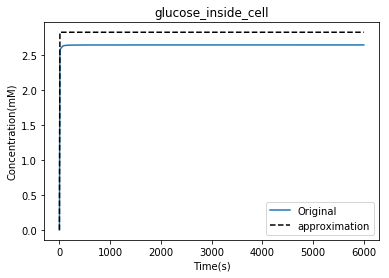

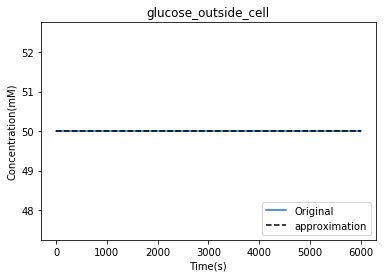

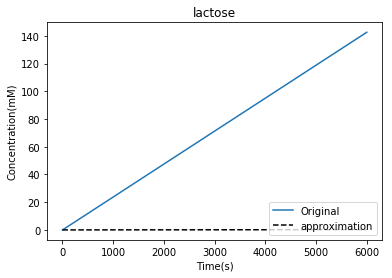

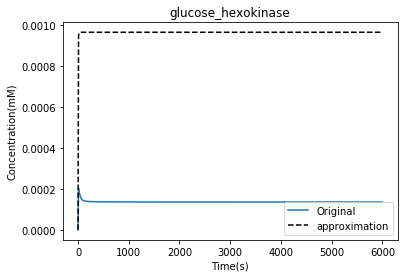

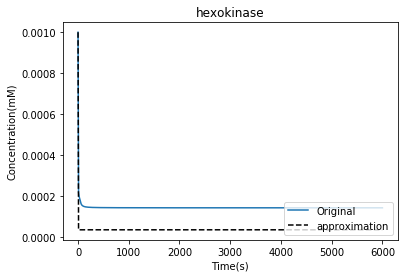

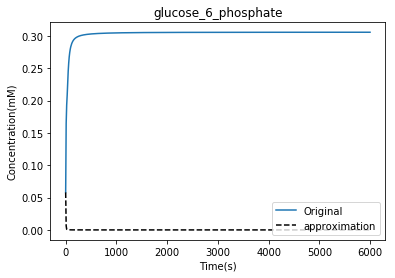

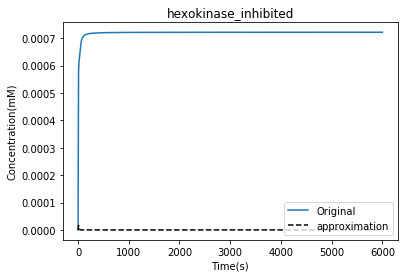

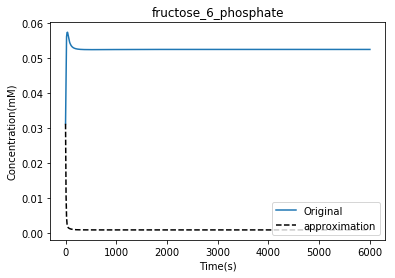

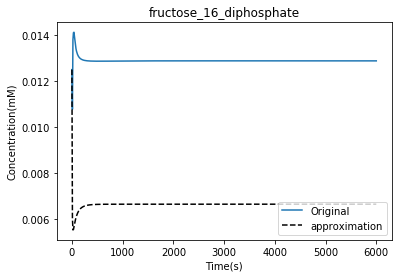

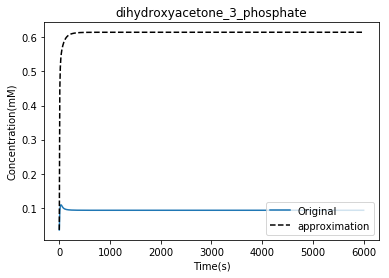

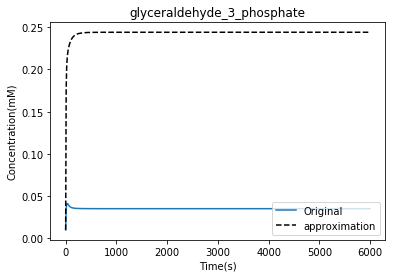

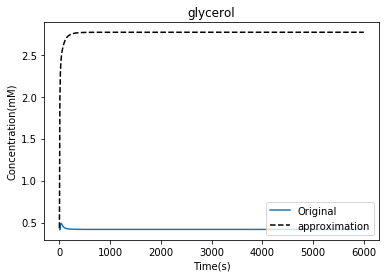

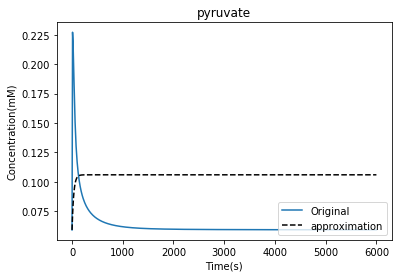

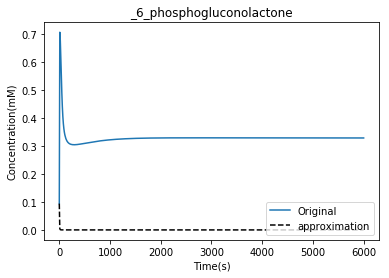

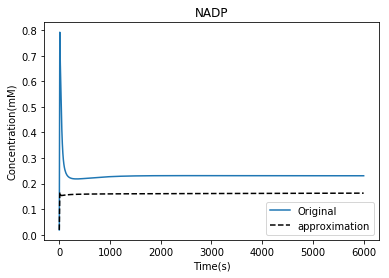

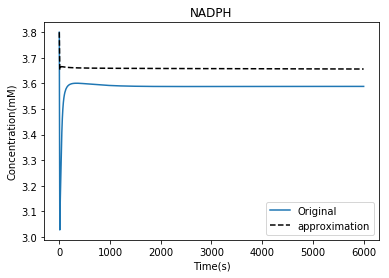

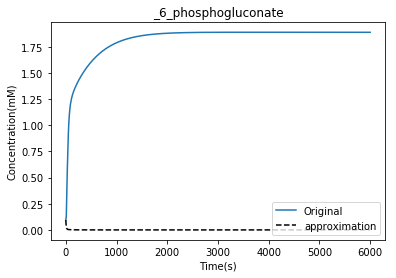

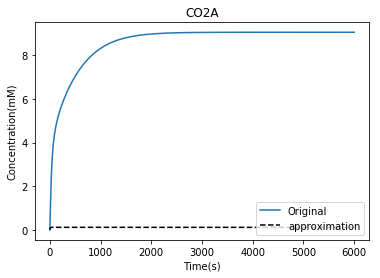

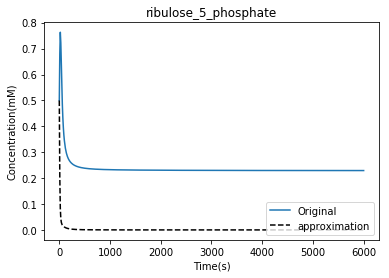

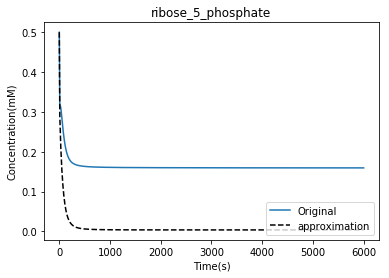

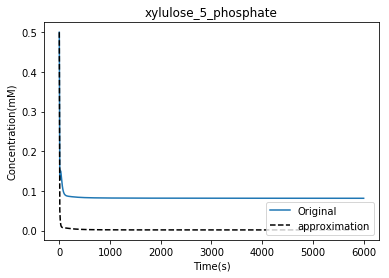

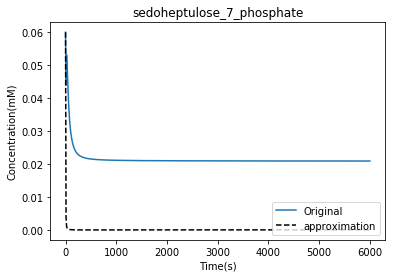

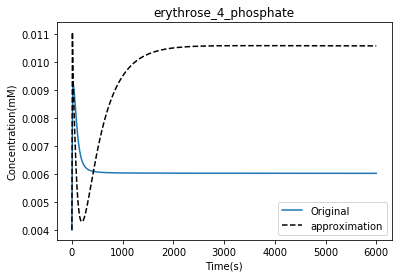

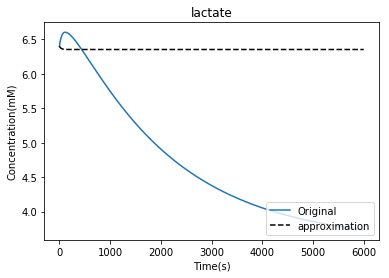

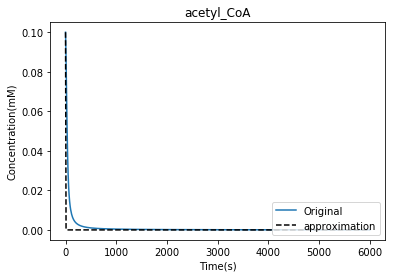

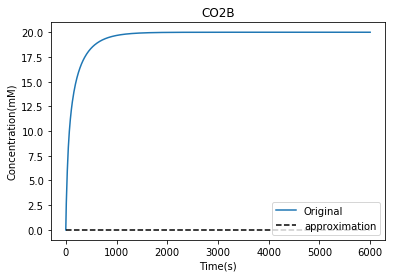

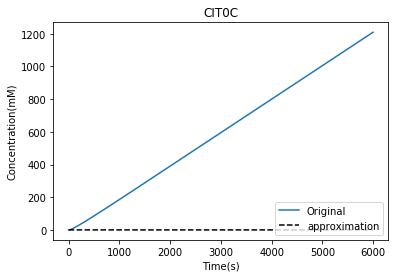

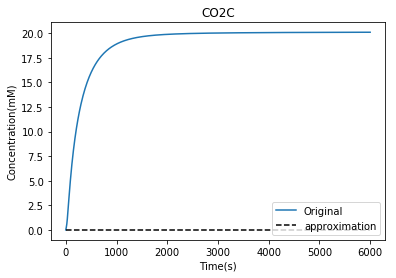

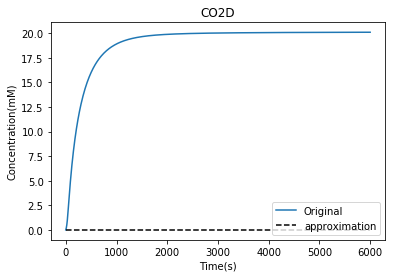

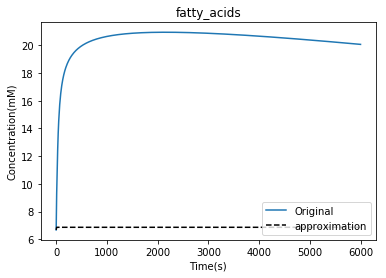

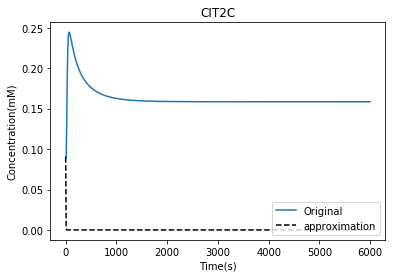

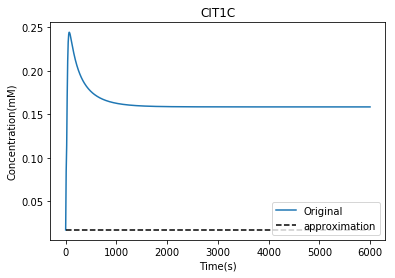

In [24]:
for stateVar,i in zip(BGmodel.state_vars,range(len(BGmodel.state_vars))):  
    if BGmodel.state_vars[stateVar][0].name in solutions:
        plt.figure()
        plt.title(BGmodel.state_vars[stateVar][0].name)
        plt.plot(solutions['time'],solutions[BGmodel.state_vars[stateVar][0].name],label='Original')
        plt.plot(t,x[:,i],'--k',label='approximation')
        plt.legend(loc='lower right')
        plt.ylabel('Concentration(mM)')
        plt.xlabel('Time(s)')